In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter,white_signals,gp_signals,signal_base
from enterprise.signals.utils import powerlaw

from enterprise.signals import anis_coefficients as ac

from enterprise_extensions import blocks
from enterprise_extensions.model_utils import get_tspan

import healpy as hp
import pickle

from la_forge.core import Core

import sys
sys.path.append('../')

from defiant import OptimalStatistic
from defiant import utils, plotting
from defiant.extra import mdc1_utils

from maps.anis_pta import anis_pta

/Users/gersbaka/opt/anaconda3/envs/pta_software/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
# For now, lets just use MDC1 pulsars
psrs,inj_params = mdc1_utils.get_mdc1_psrs()
pta = mdc1_utils.create_MDC1_PTA(psrs)

OS_obj = OptimalStatistic(psrs,pta,'gw','MDC1_FG_CURN_samples.core')

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.
Loading data from HDF5 file....


In [3]:
nside = 4
npix = hp.nside2npix(nside)

lmax = 2
m_modes = (lmax+1)**2


In [4]:
gwtheta,gwphi = hp.pix2ang(nside,np.arange(npix))

psrtheta = np.array([p.theta for p in psrs])
psrphi = np.array([p.phi for p in psrs])

print(f'Number of pulsars: {len(psrs)}, Number of pairs: {len(psrs)*(len(psrs)-1)/2}, '+
      f'Nside: {nside}, Number of pixels: {npix}')

Number of pulsars: 36, Number of pairs: 630.0, Nside: 4, Number of pixels: 192


In [5]:
temp = ac.signalResponse_fast(psrtheta,psrphi,gwtheta,gwphi)
Fp,Fc = temp[:,0::2],temp[:,1::2] 
# The F plus and F cross values are already normalized!

In [6]:
npairs = OS_obj.npairs
pair_idx = OS_obj._pair_idx

R_abk = np.zeros( (npairs,npix) )
# Now lets do some multiplication
for i,(a,b) in enumerate(pair_idx):
    R_abk[i] = Fp[a]*Fp[b] + Fc[a]*Fc[b]

print(R_abk.shape)

(630, 192)


In [7]:
# Now lets check if R_abk is the same as MAPS
maps_obj = anis_pta(psrtheta,psrphi,nside=nside,l_max=lmax)
maps_obj.F_mat.shape

(630, 192)

In [8]:
np.allclose(R_abk,maps_obj.F_mat)

True

## Sick, now lets try making spherical harmonics R_lm

In [9]:
psr_locs = np.array([psrphi,psrtheta]).T

shape_R_lm = ac.anis_basis(psr_locs,lmax,nside)
print(shape_R_lm.shape)

# (modes, pulsar, pulsar)
# Basis will be (m=0,l=0), (m=1,l=-1), (m=1,l=0), (m=1,l=1), (m=2,l=-2)...

# We need to reorient the P_lm matrix to be (pair, modes)
#pair_idx = np.array([(a,b) for a in range(36) for b in range(a+1,36)])
#a,b = pair_idx[:,0],pair_idx[:,1]
#idx = np.arange(len(a))

R_lm = np.zeros( (npairs, m_modes) )

for i,(a,b) in enumerate(pair_idx):
    R_lm[i] = shape_R_lm[:,a,b]

print(R_lm.shape)

(9, 36, 36)
(630, 9)


In [14]:
print(maps_obj.Gamma_lm.T.shape)
print(np.allclose(maps_obj.Gamma_lm.T,R_lm))

(630, 9)
True


In [14]:
[f'Y_{l},{m}' for l in range(lmax+1) for m in range(-l,l+1)]

['Y_0,0',
 'Y_1,-1',
 'Y_1,0',
 'Y_1,1',
 'Y_2,-2',
 'Y_2,-1',
 'Y_2,0',
 'Y_2,1',
 'Y_2,2']

## Lets try using the radiometer pixel basis

In [36]:
# For now, lets just use MDC1 pulsars
psrs,inj_params = mdc1_utils.get_mdc1_psrs()
pta = mdc1_utils.create_MDC1_PTA(psrs)

OS_obj = OptimalStatistic(psrs,pta,'gw','MDC1_FG_CURN_samples.core')

Loading data from HDF5 file....


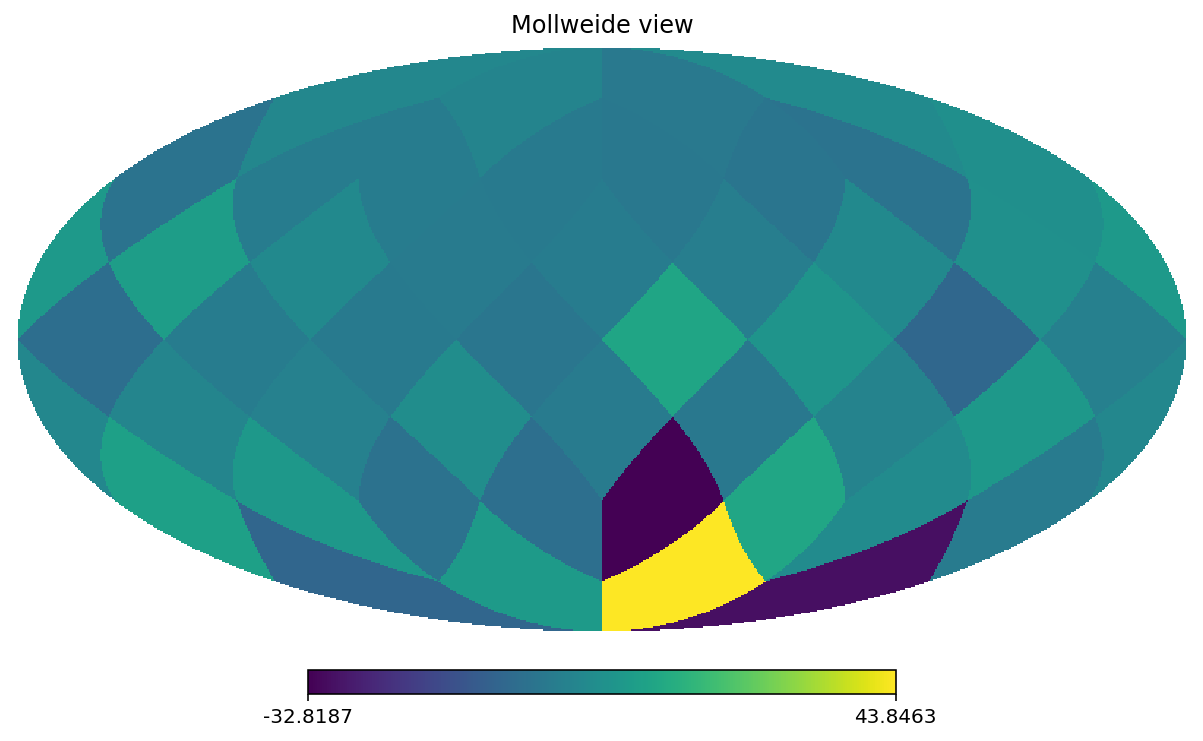

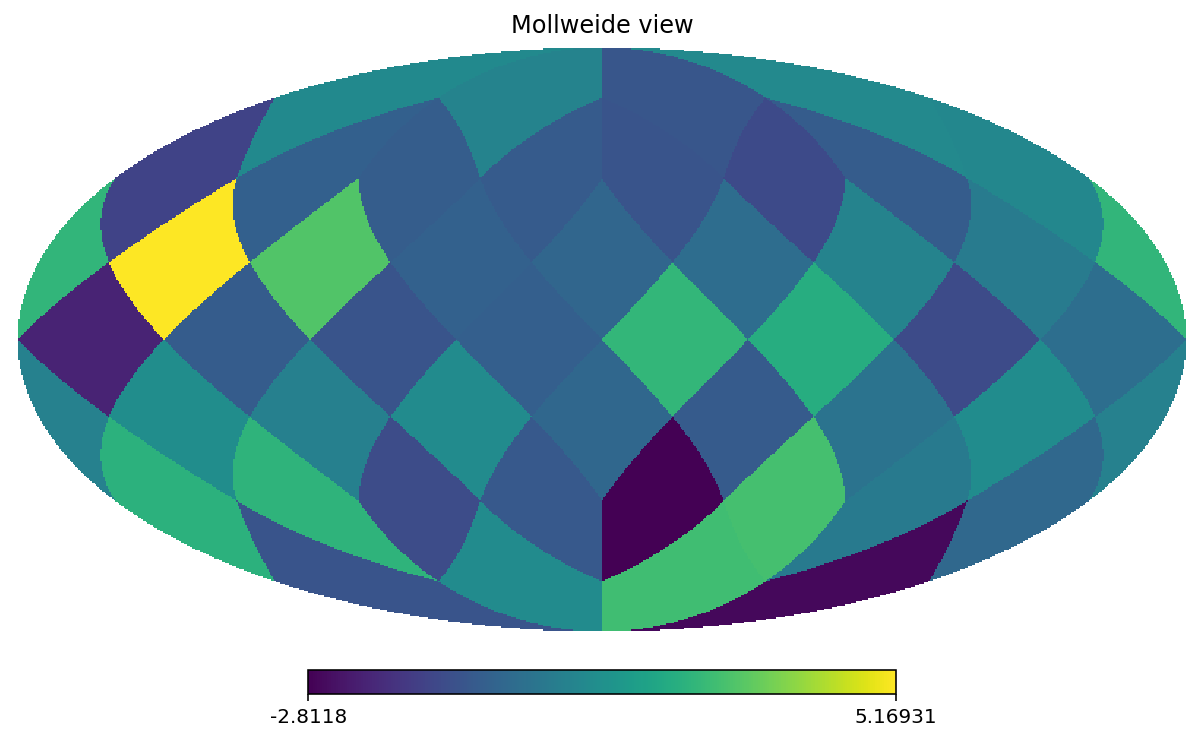

In [37]:
OS_obj.set_anisotropy_basis('pixel',2,4,'hd')
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params)

hp.mollview(A2/(10**(2*inj_params['gw_log10_A'])))
plt.show()

hp.mollview(A2/np.sqrt(np.diag(A2s)),)
plt.show()

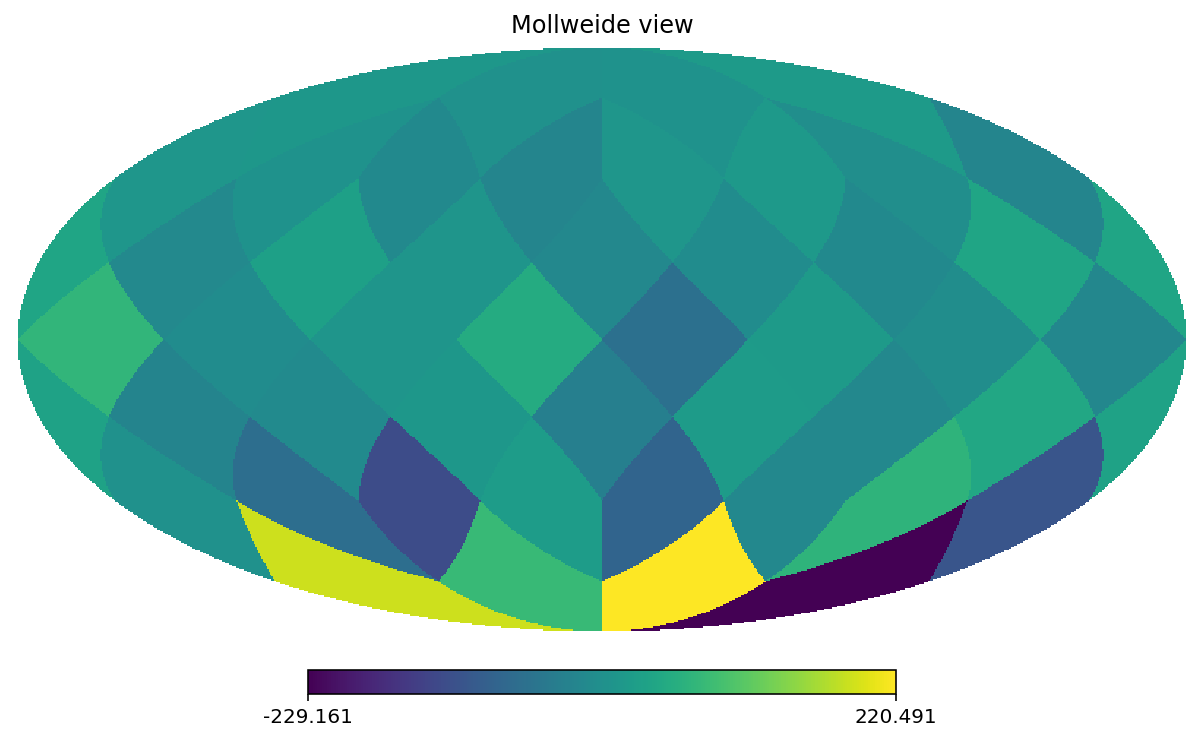

/var/folders/bb/_0rqpxpd2cl3kcsqv4vkt18h0000gq/T/ipykernel_6723/1119821504.py:7: RuntimeWarning: invalid value encountered in sqrt
  hp.mollview(A2/np.sqrt(np.diag(A2s)),)


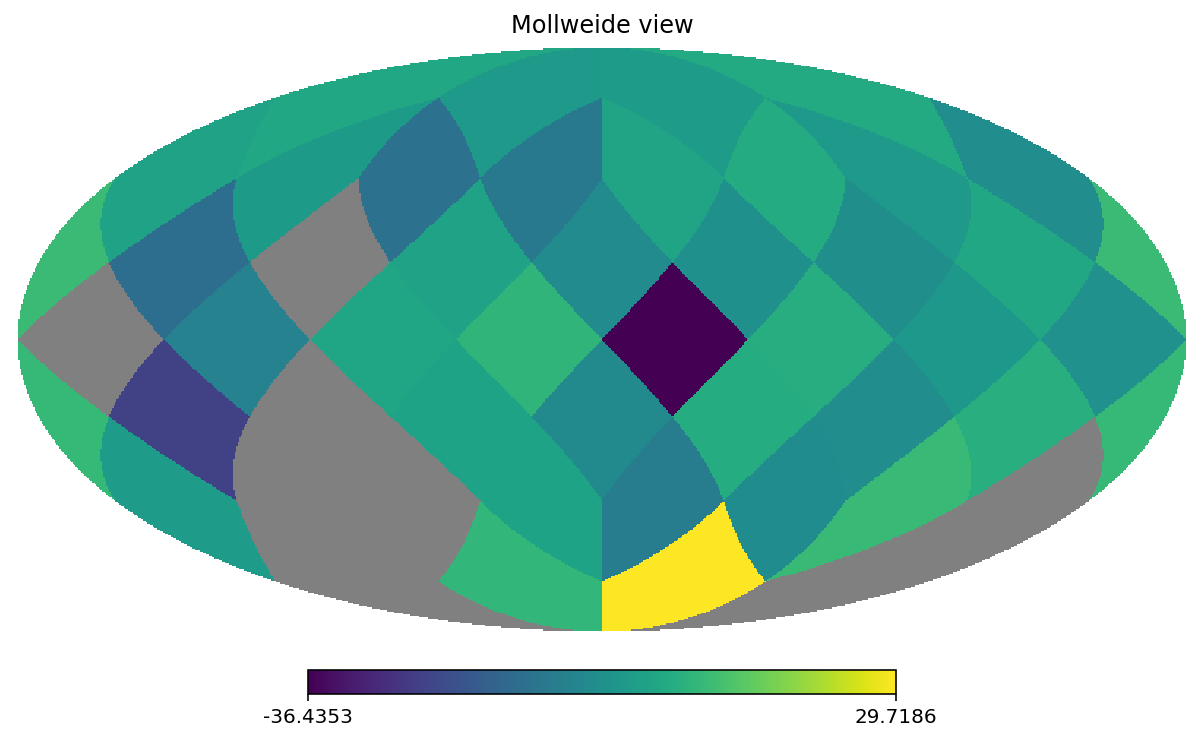

In [38]:
OS_obj.set_anisotropy_basis('pixel',2,4,'hd')
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params,pair_covariance=True)

hp.mollview(A2/(10**(2*inj_params['gw_log10_A'])))
plt.show()

hp.mollview(A2/np.sqrt(np.diag(A2s)),)
plt.show()


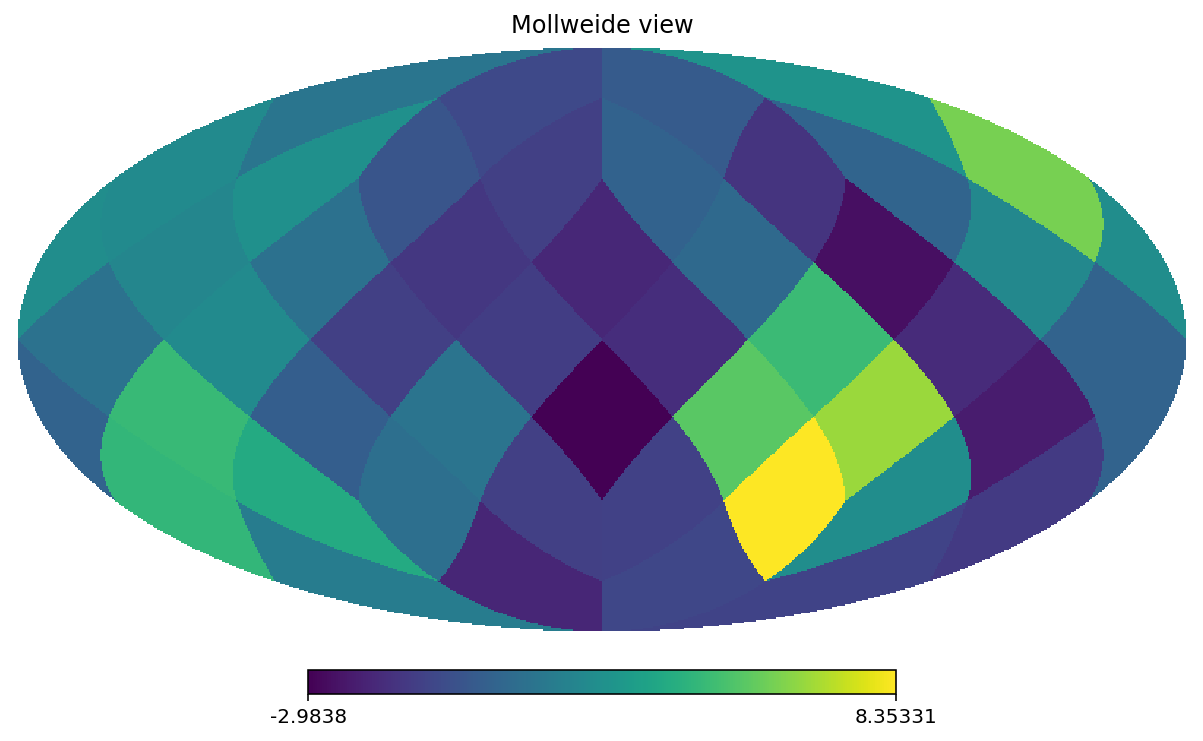

/var/folders/bb/_0rqpxpd2cl3kcsqv4vkt18h0000gq/T/ipykernel_6723/3343636811.py:10: RuntimeWarning: invalid value encountered in sqrt
  hp.mollview(map/np.sqrt(map_s))


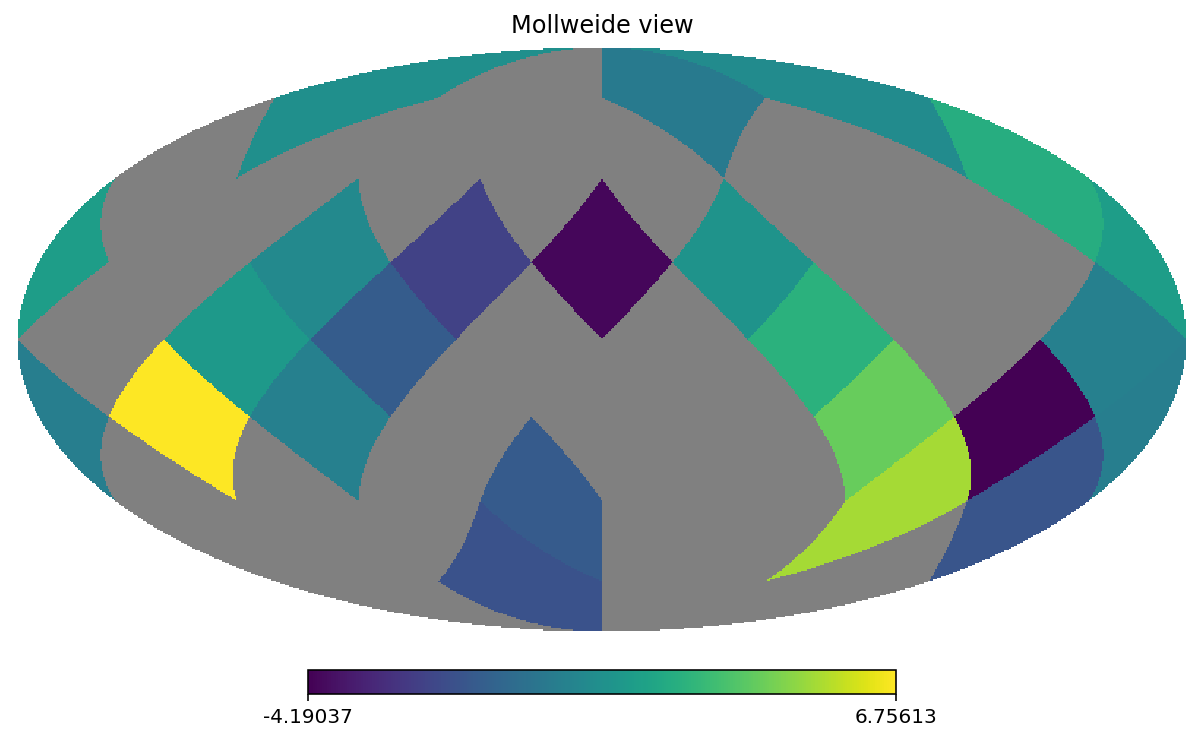

In [42]:
OS_obj.set_anisotropy_basis('spherical',2,4,'hd')
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params)

map = ac.mapFromClm(A2,OS_obj.nside)
map_s = ac.mapFromClm(np.diag(A2s),OS_obj.nside)

hp.mollview(map/(10**(2*inj_params['gw_log10_A'])))
plt.show()

hp.mollview(map/np.sqrt(map_s))
plt.show()


## Now lets try with an actual anisotropic PTA

In [43]:
with open('freshforkyle_mdc_style_cw.pkl','rb') as f:
    psrs = pickle.load(f)


Tspan = get_tspan(psrs)

efac = parameter.Constant(1.0)
ef = white_signals.MeasurementNoise(efac=efac)

curn = blocks.common_red_noise_block(psd='powerlaw',Tspan=Tspan,components=10,
                                     gamma_val=13./3.,logmin=-18,logmax=-12,name='gw')

tm = gp_signals.MarginalizingTimingModel(use_svd=True)

model = tm + ef + curn

pta = signal_base.PTA([model(psr) for psr in psrs])

In [44]:
OS_obj = OptimalStatistic(psrs,pta=pta,gwb_name='gw',core_path='anisotropy_CURN.core')

Loading data from HDF5 file....


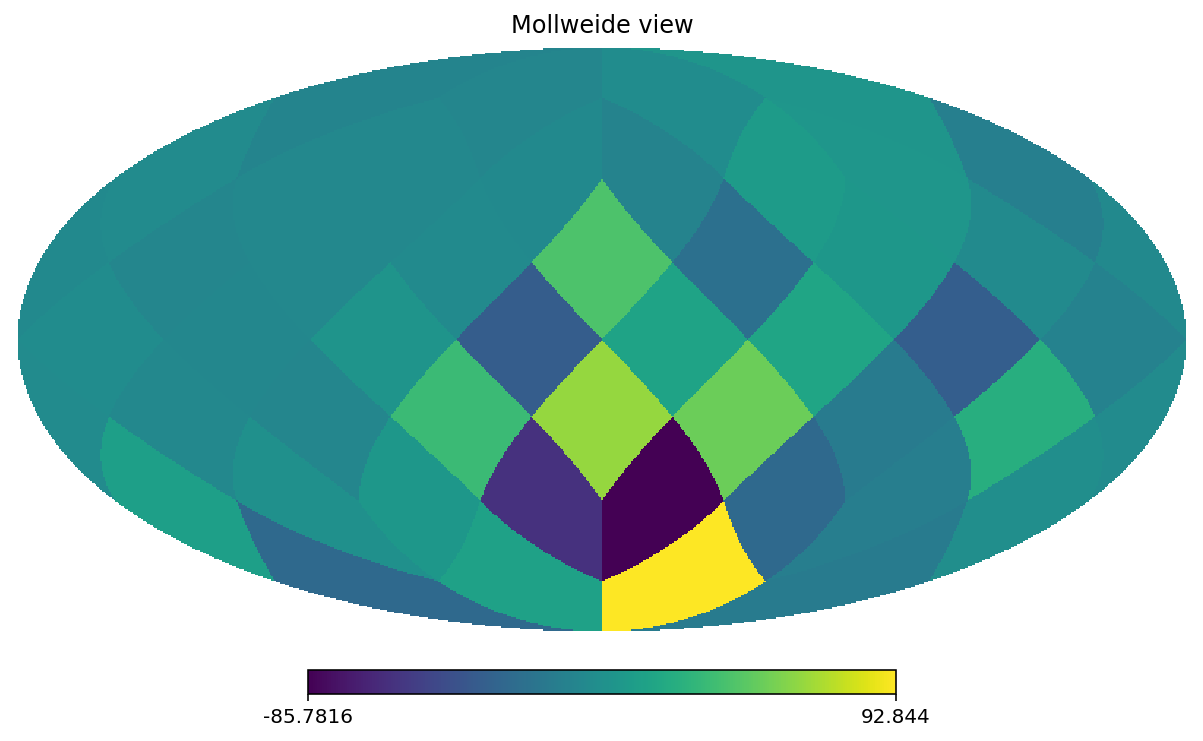

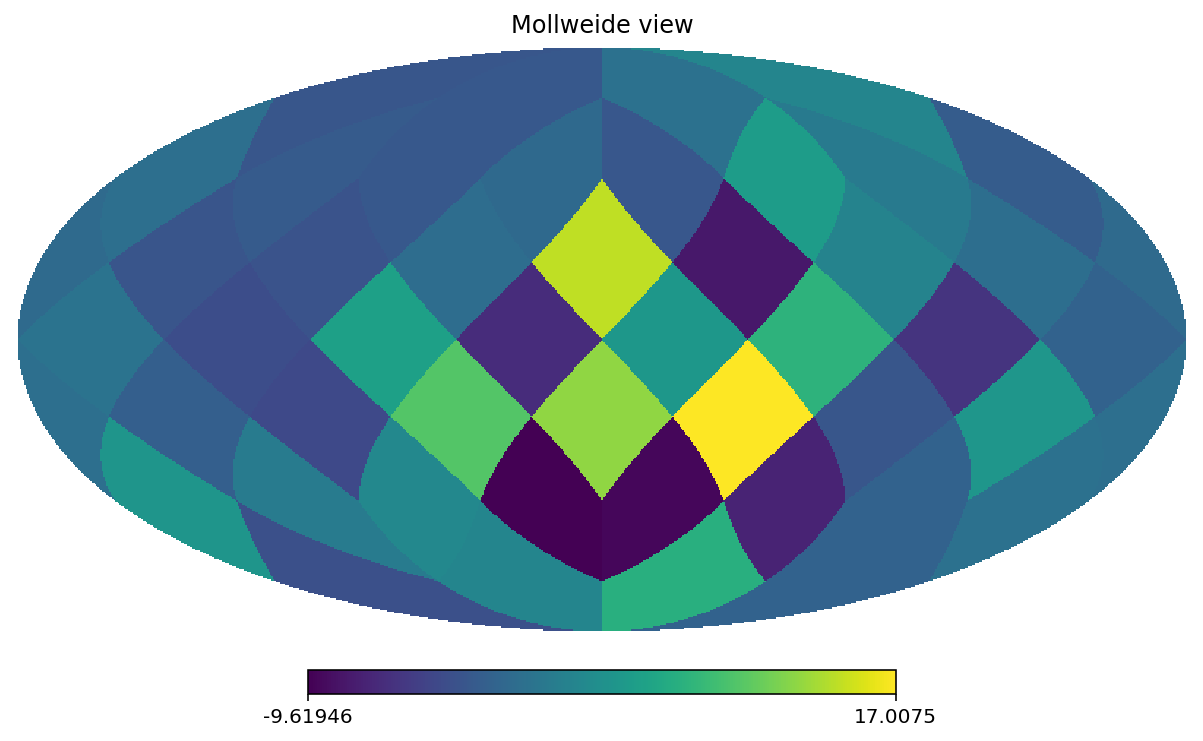

In [46]:
OS_obj.set_anisotropy_basis('pixel',2,4,'hd')
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params)

hp.mollview(A2/(10**(2*inj_params['gw_log10_A'])))
plt.show()

hp.mollview(A2/np.sqrt(np.diag(A2s)),)
plt.show()

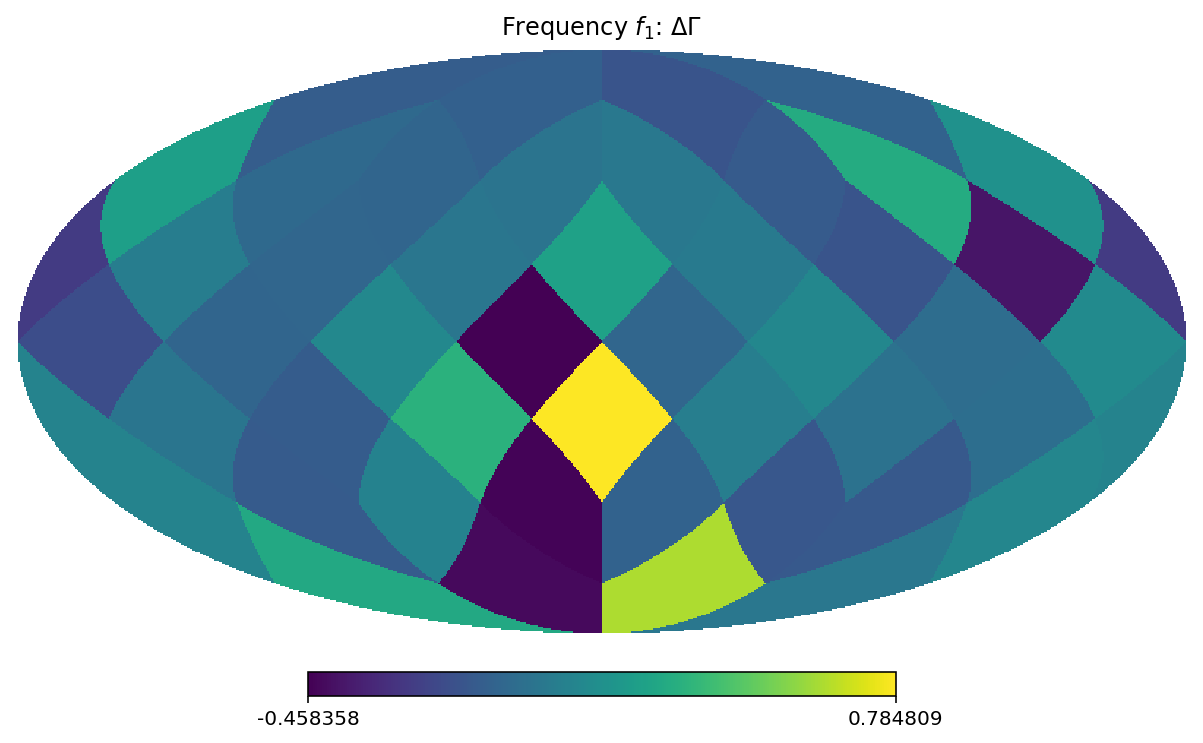

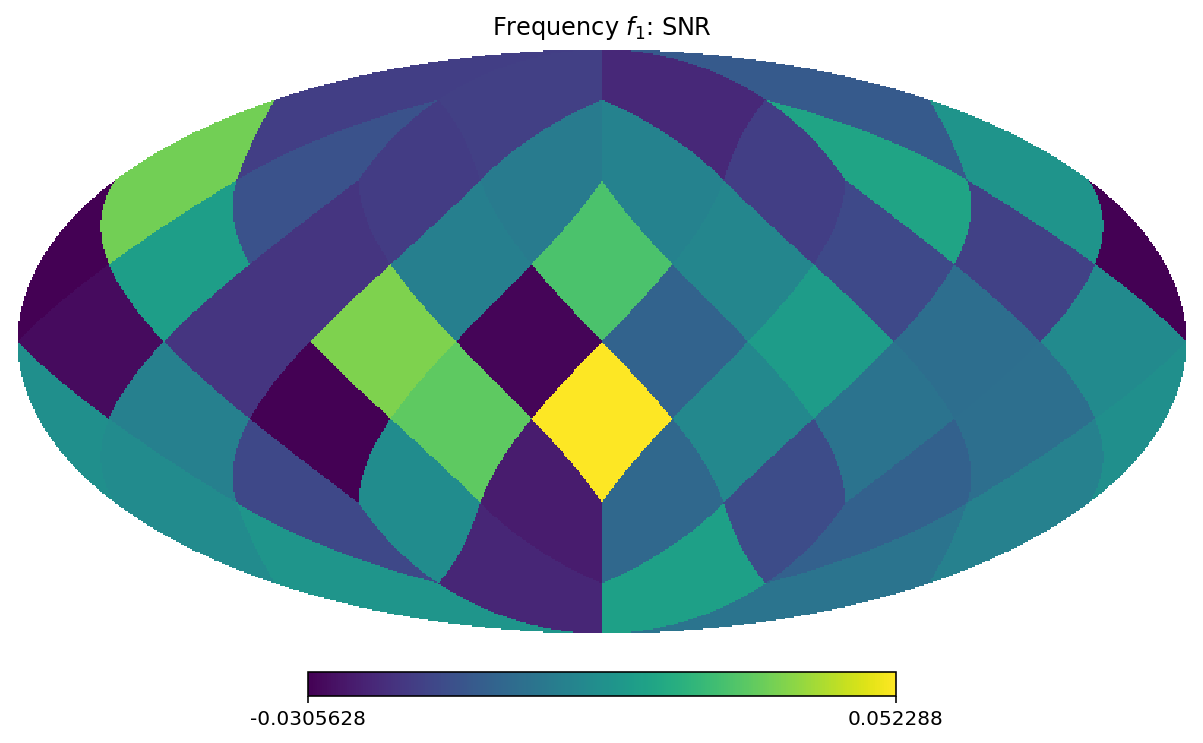

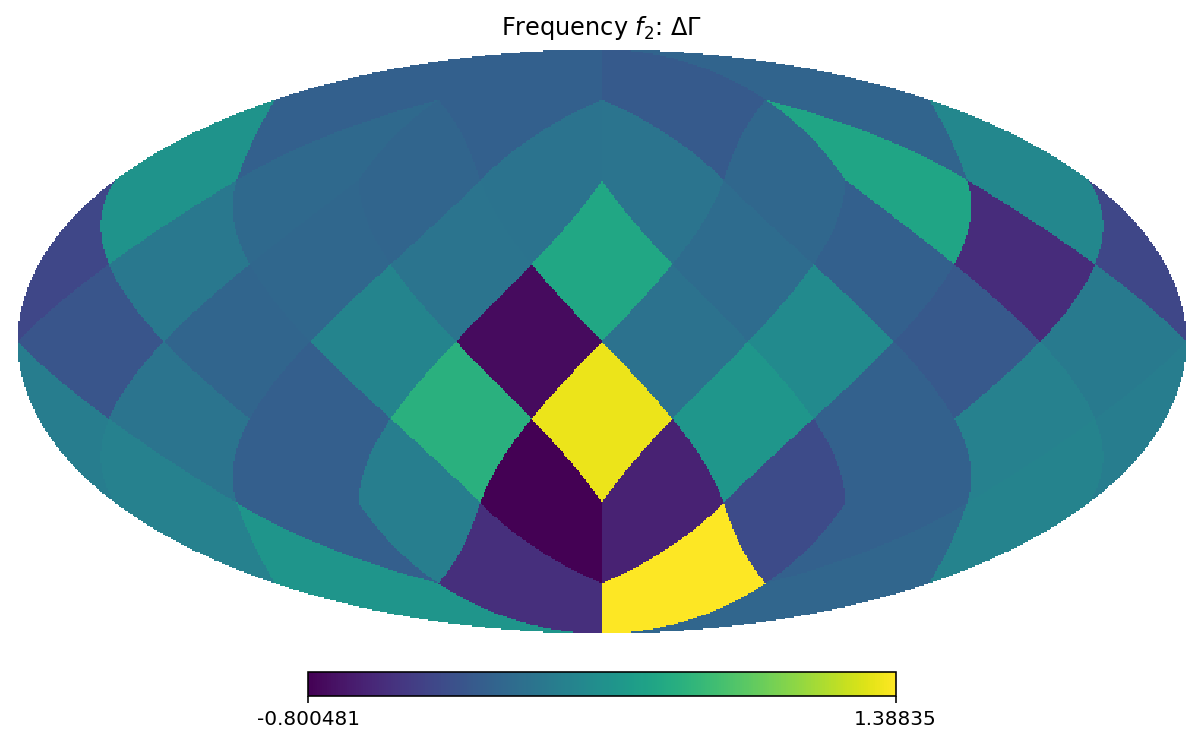

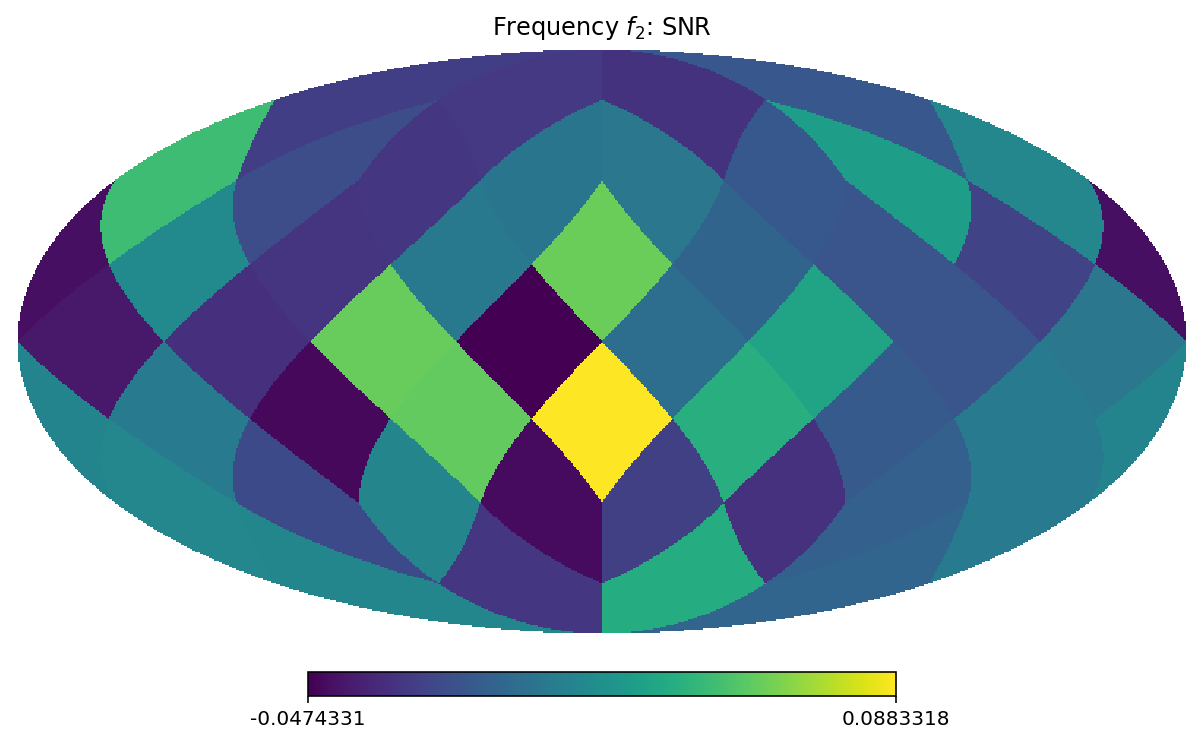

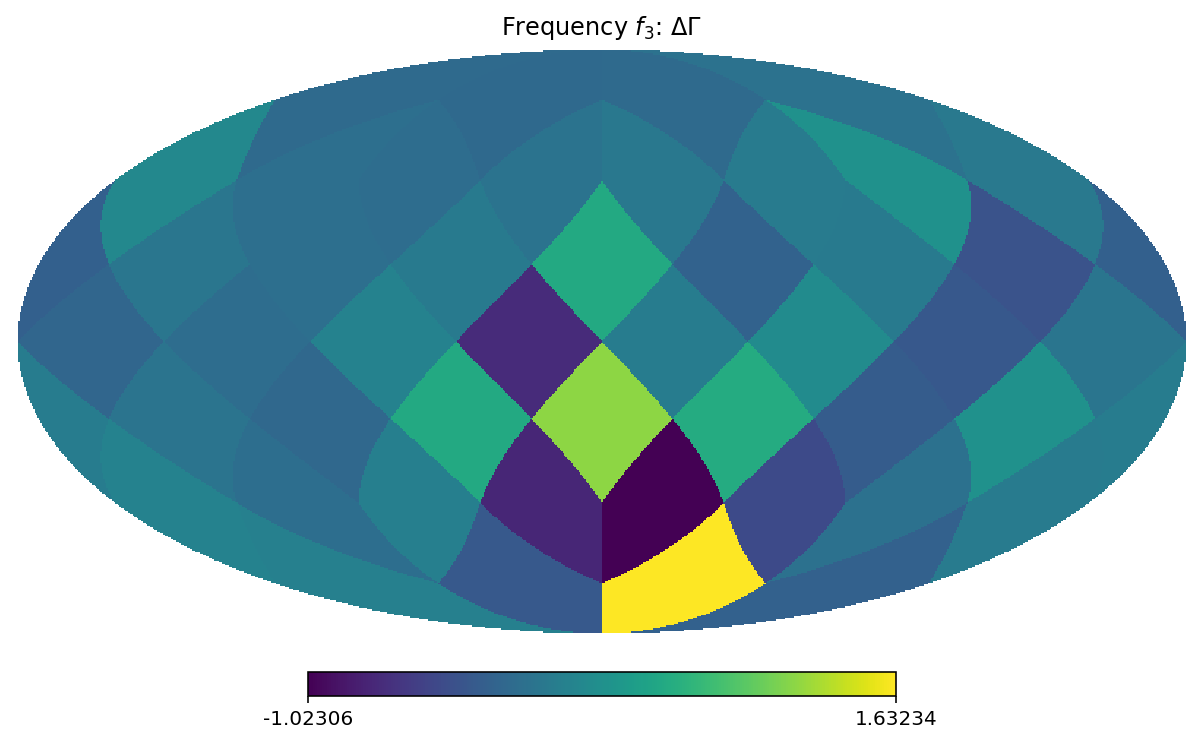

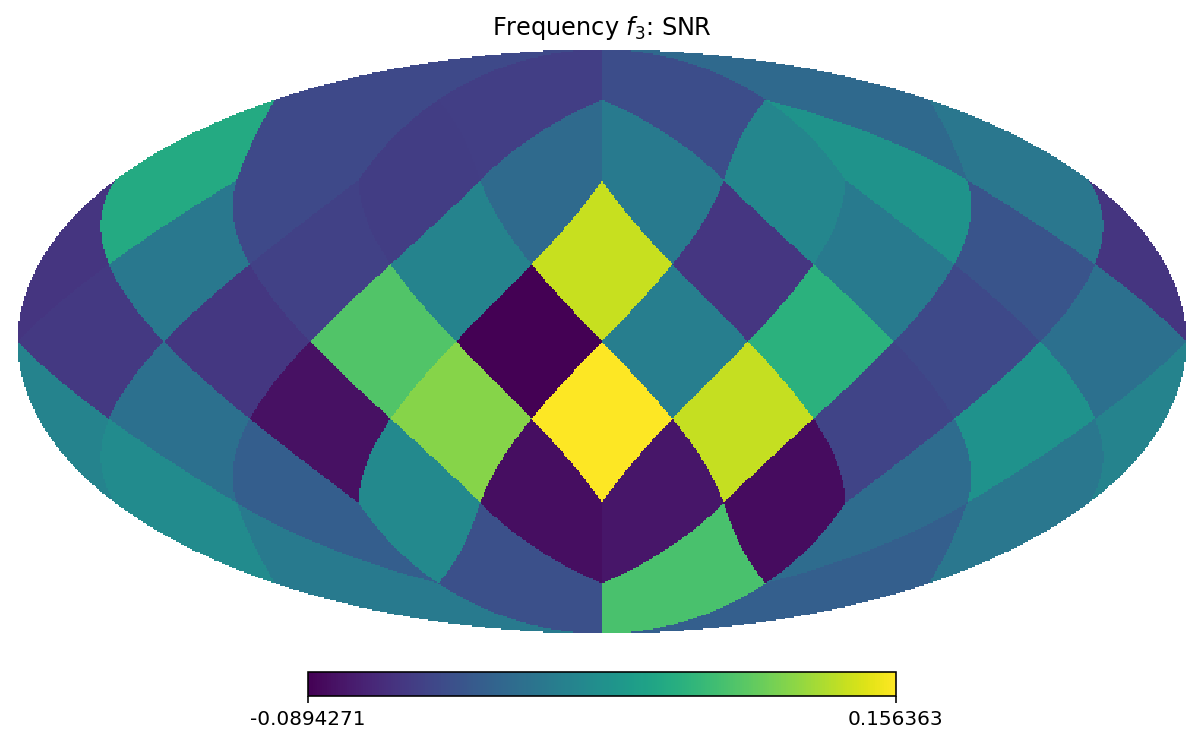

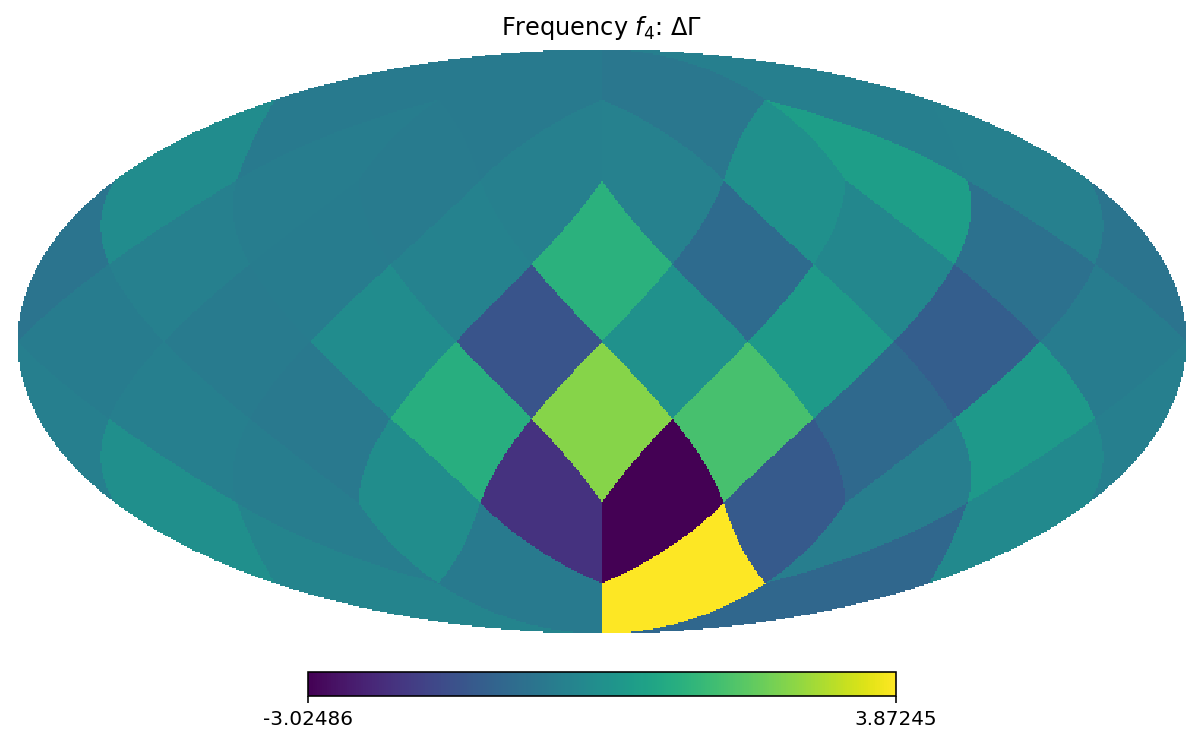

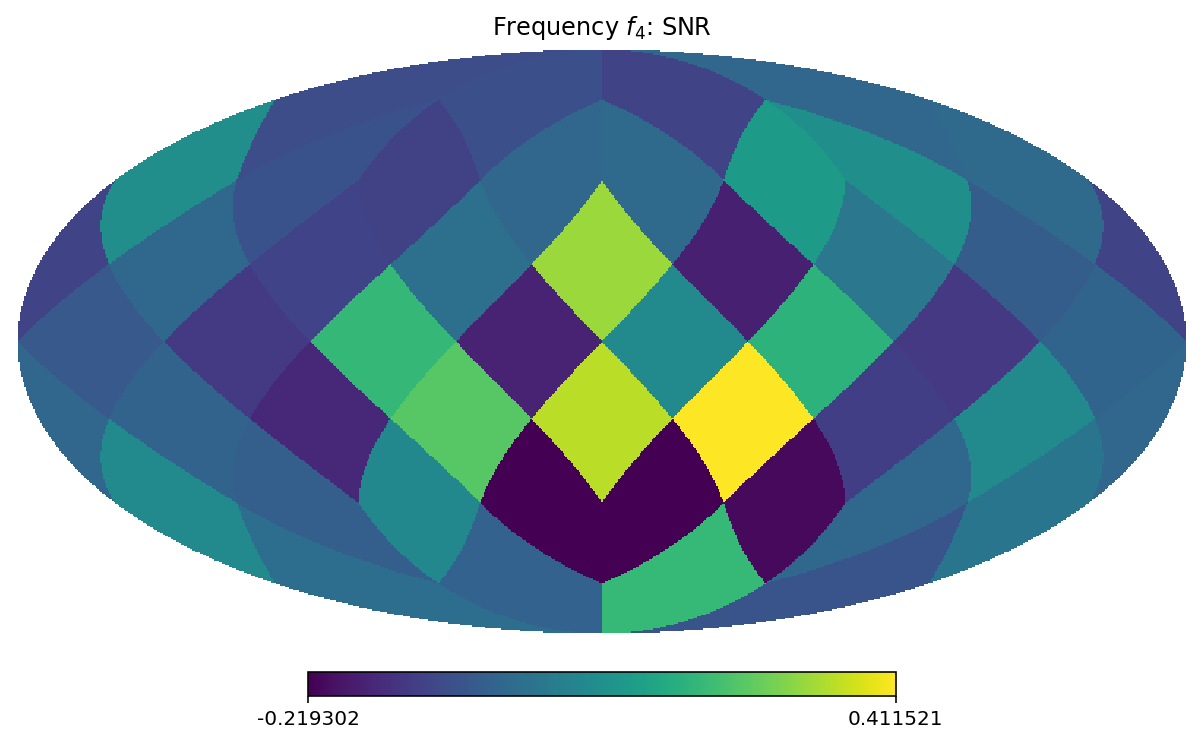

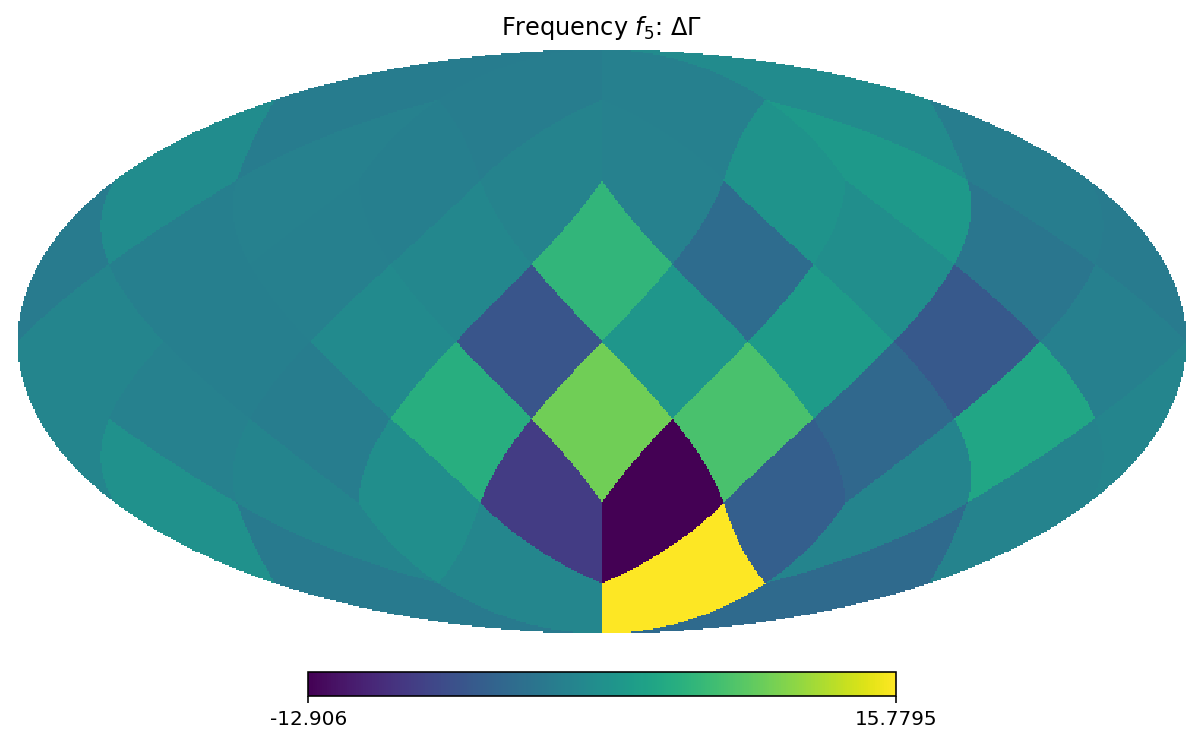

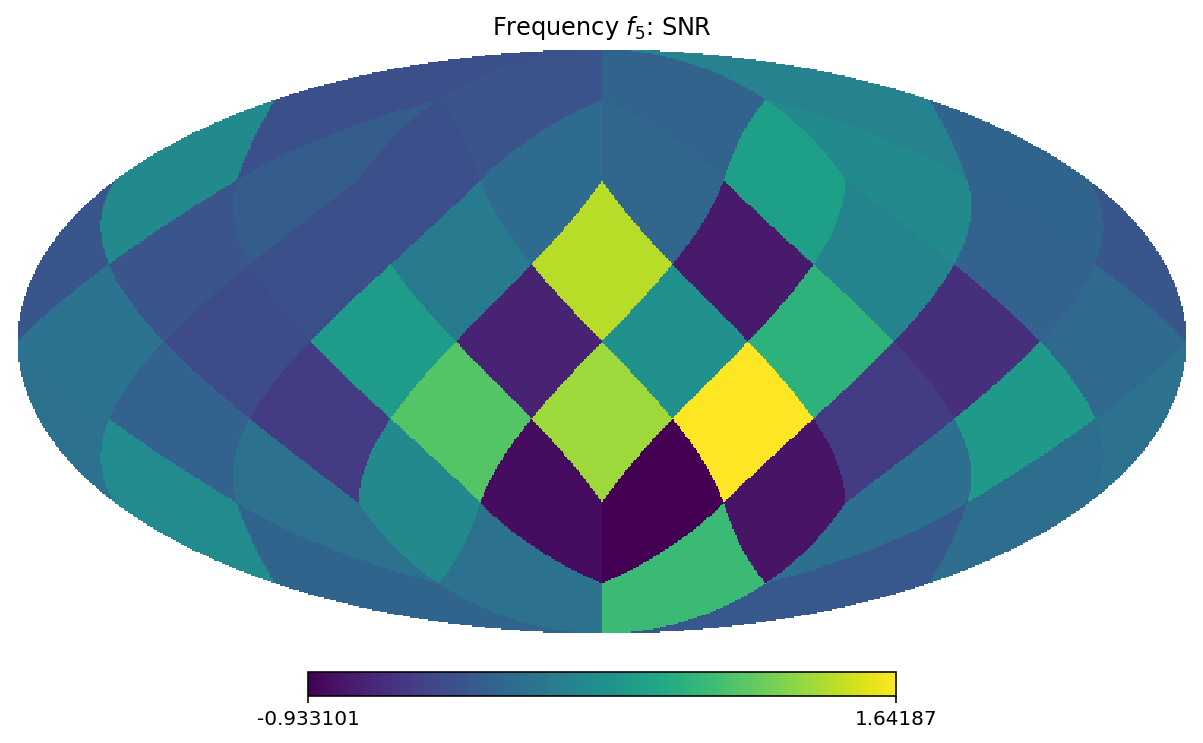

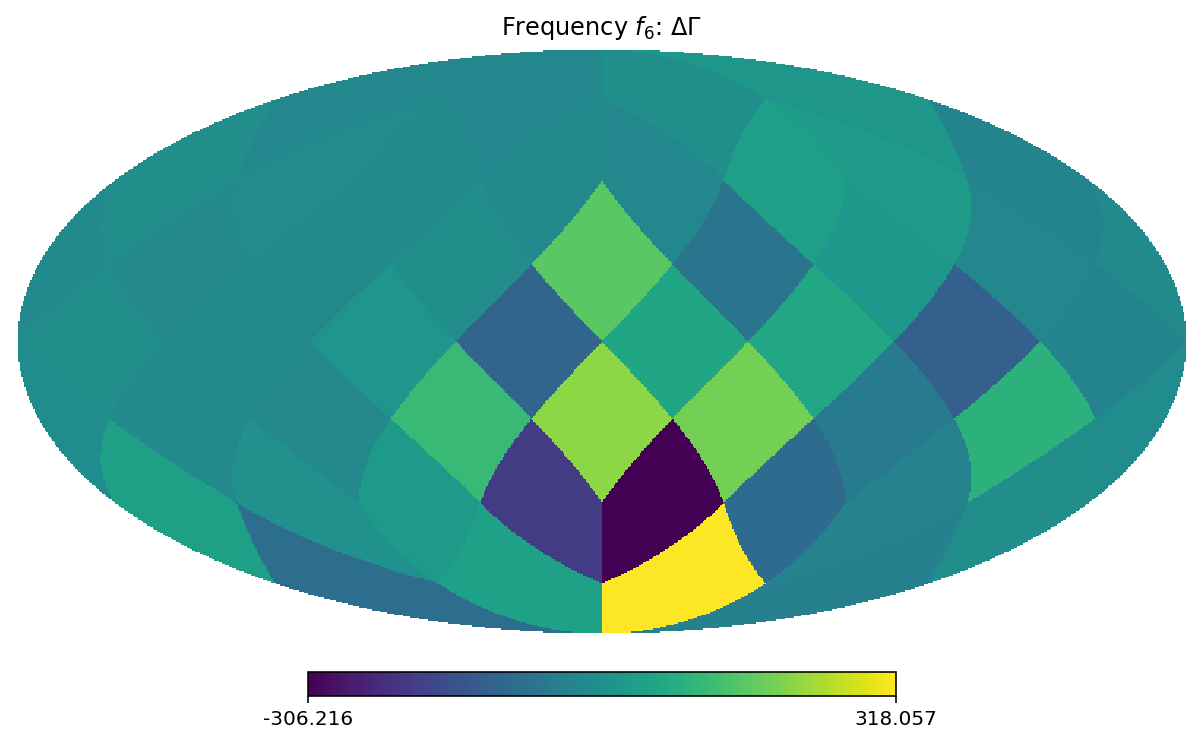

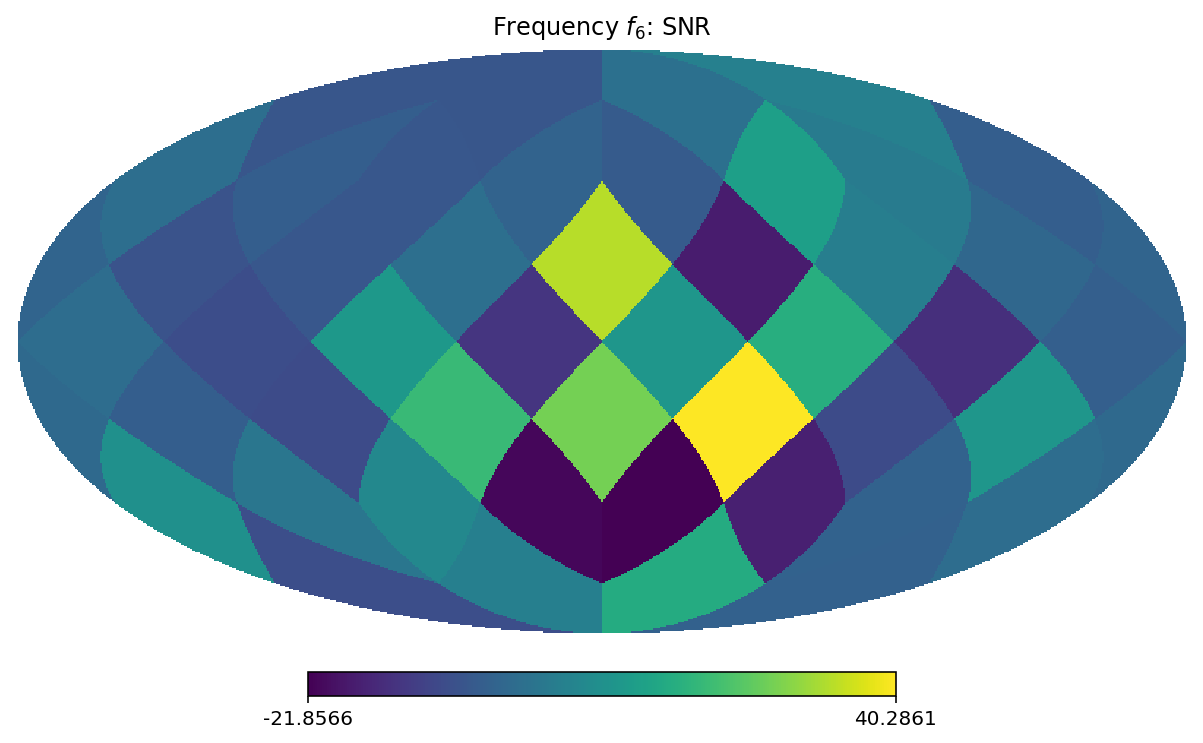

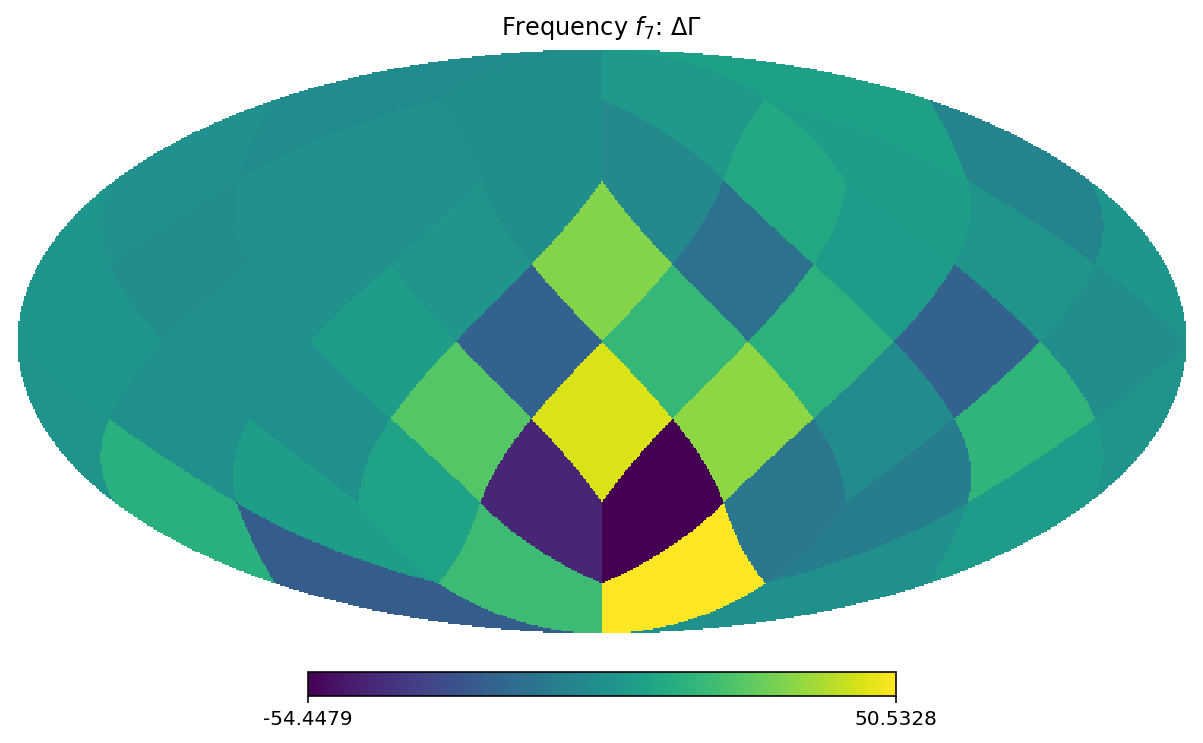

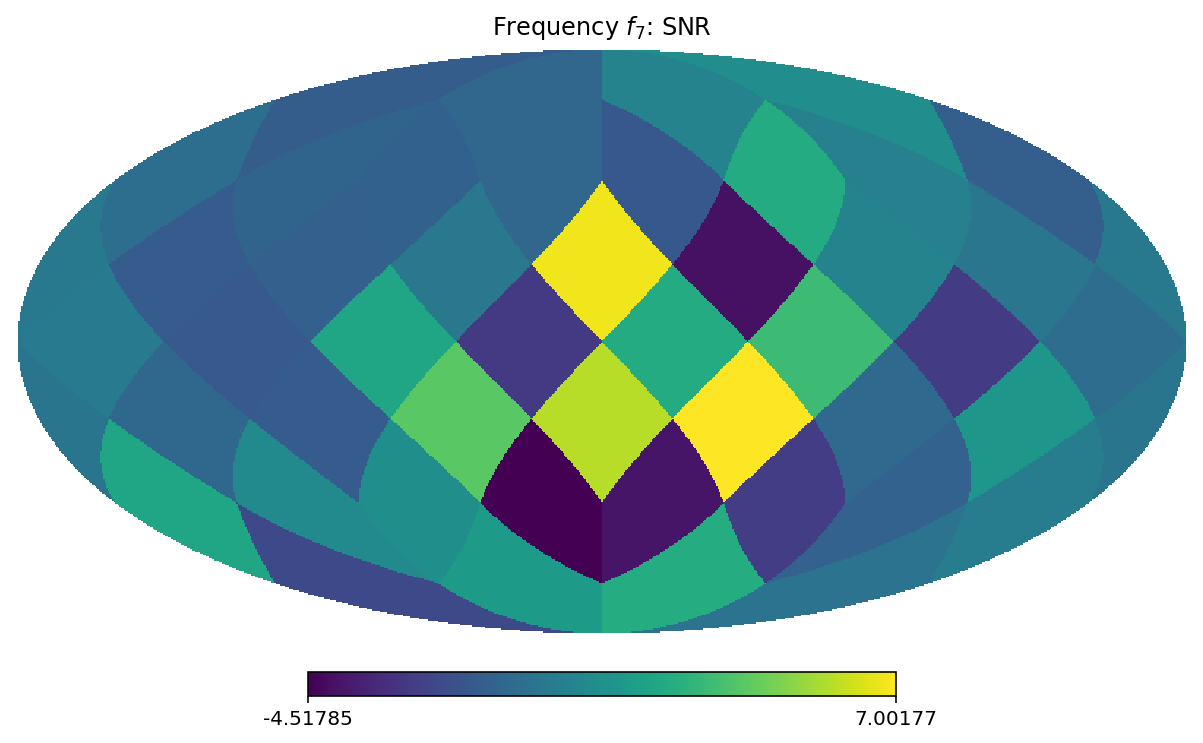

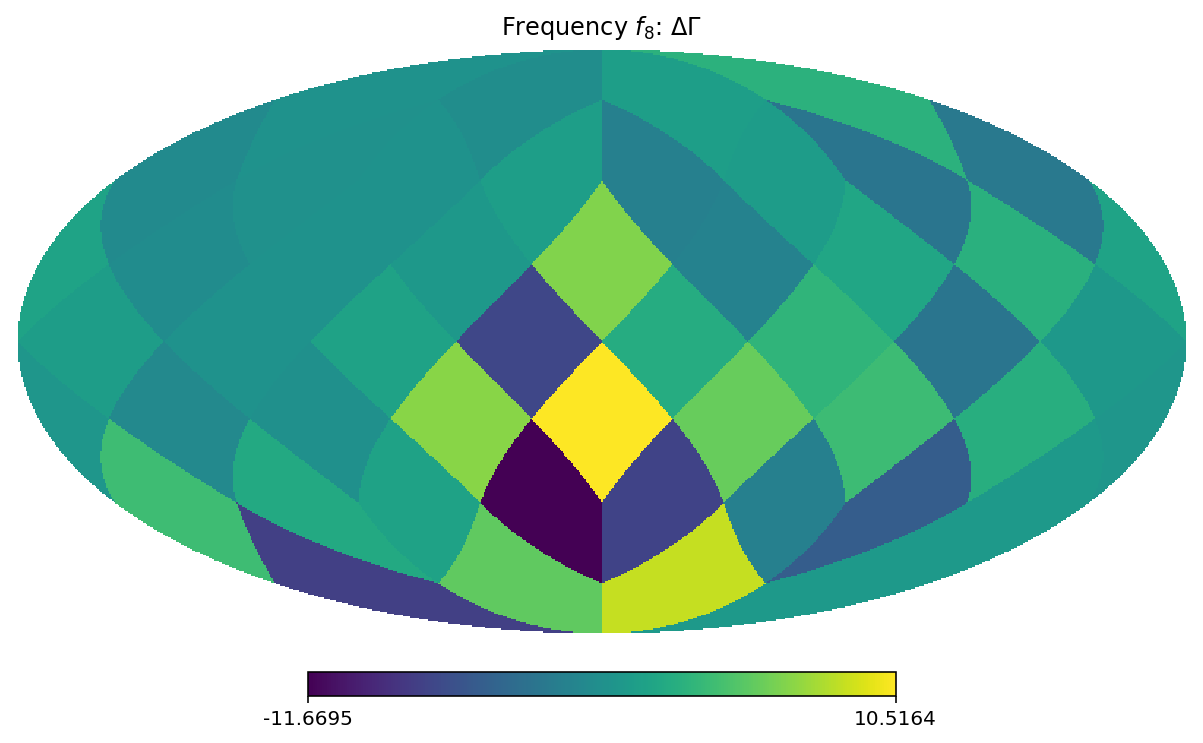

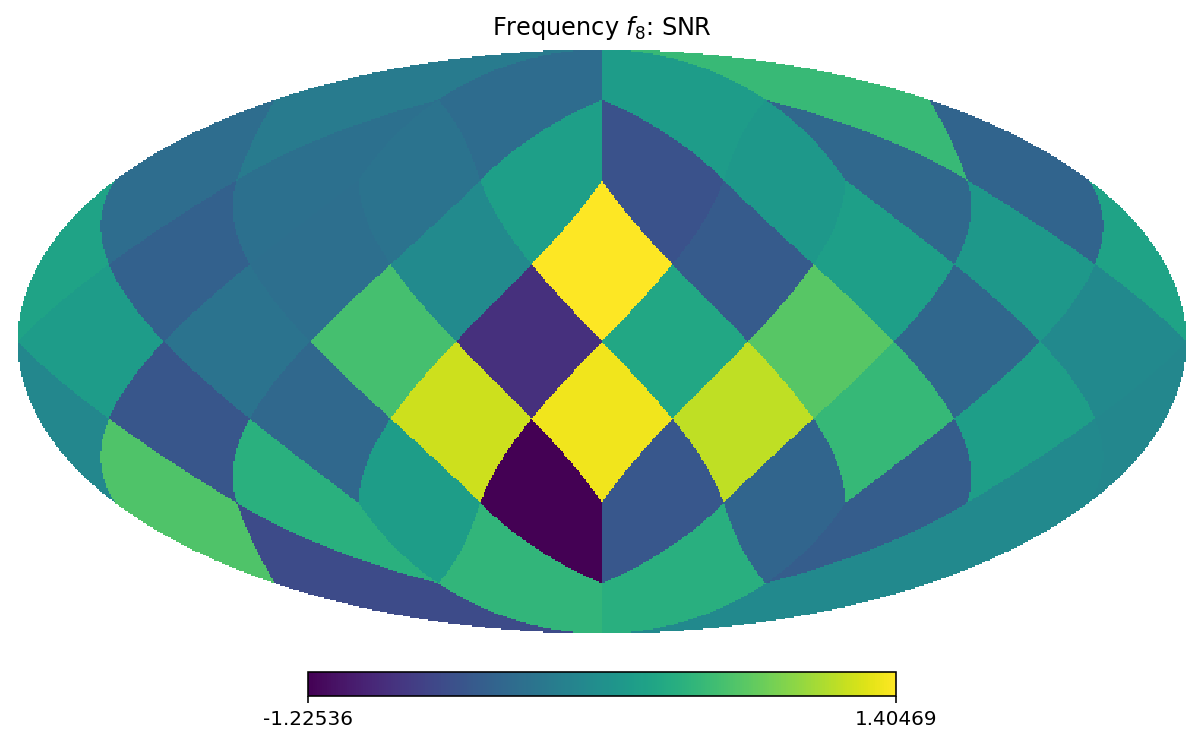

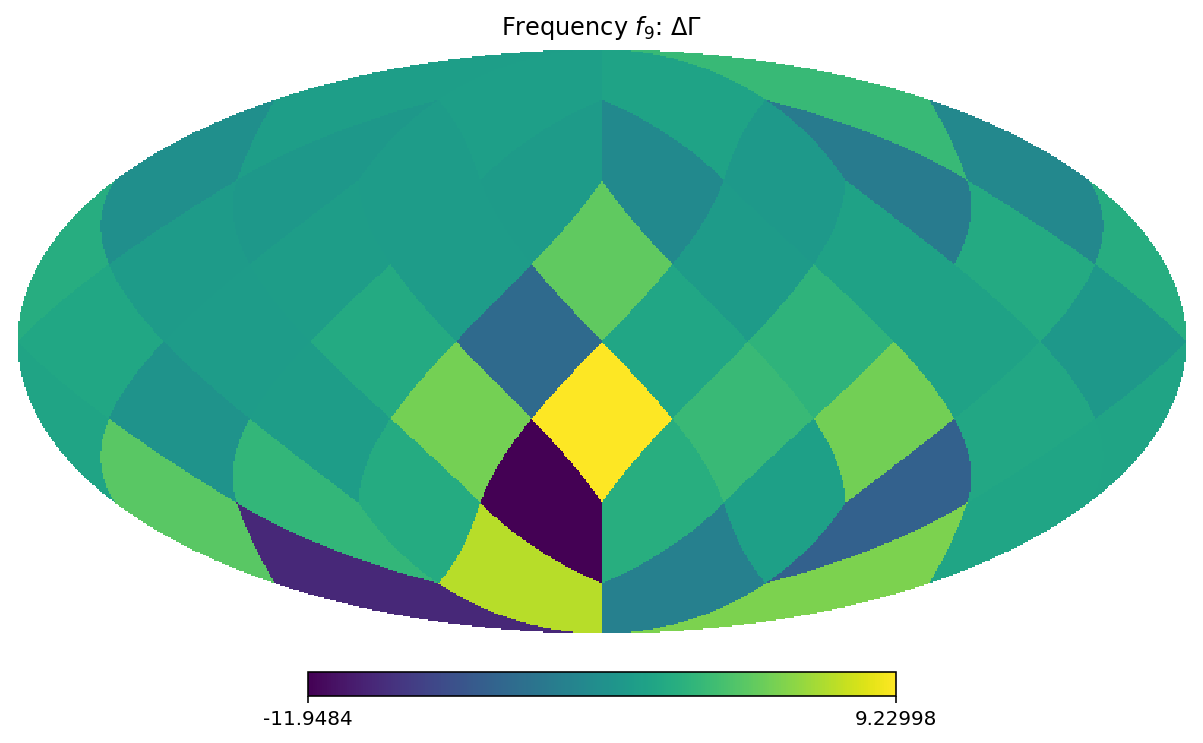

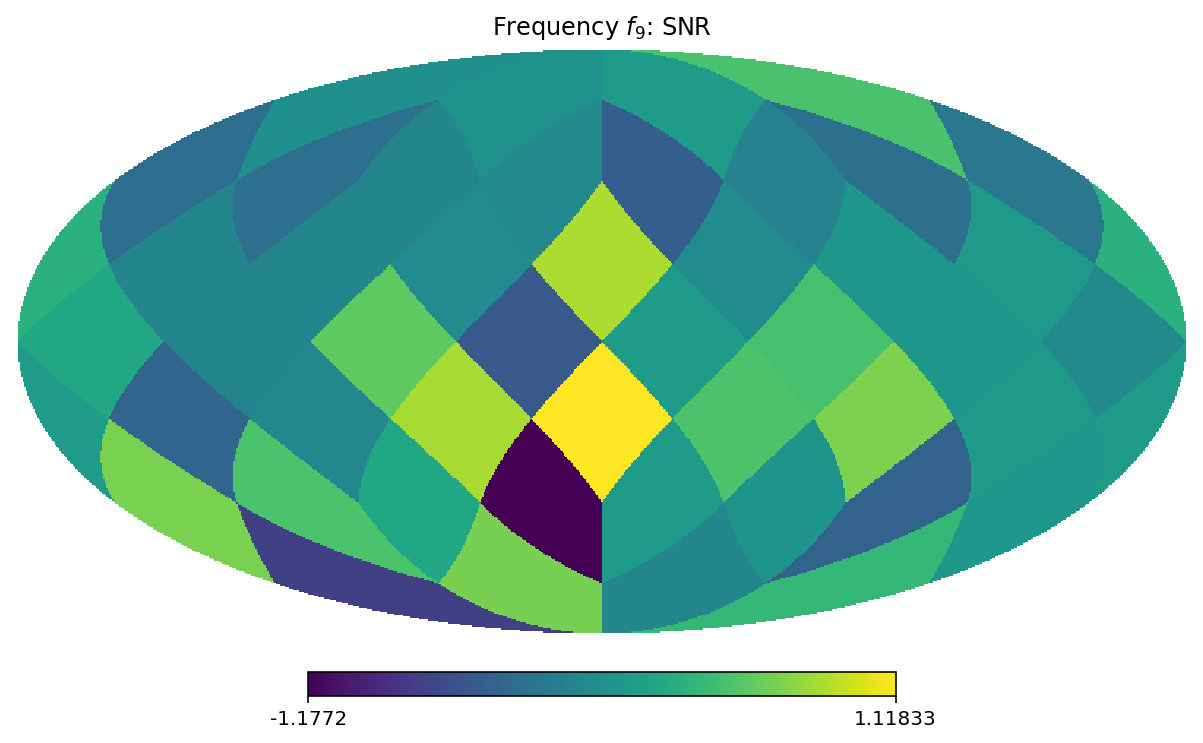

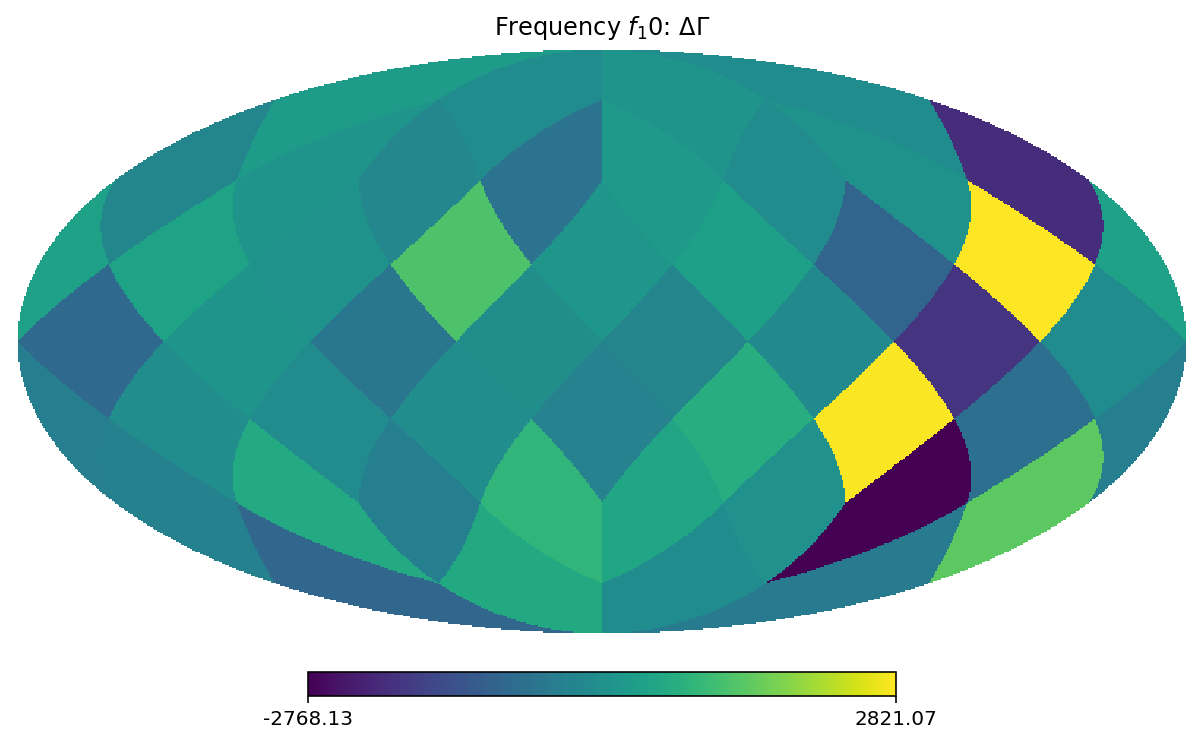

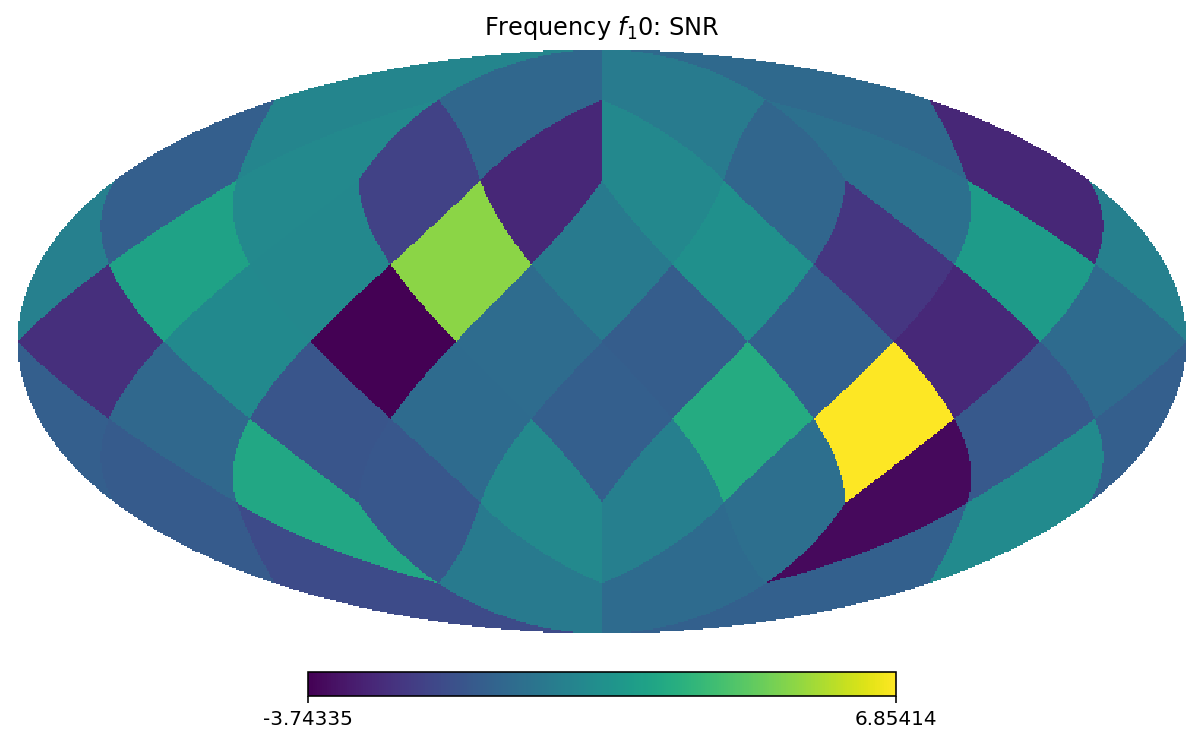

In [51]:
OS_obj.set_anisotropy_basis('pixel',2,4,'hd')
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(inj_params)

inj_sk = powerlaw(OS_obj.freqs,inj_params['gw_log10_A'],inj_params['gw_gamma'])

for i in range(OS_obj.nfreq):
    hp.mollview(Sk[i]/inj_sk[i])
    plt.title(f'Frequency $f_{i+1}$: $\Delta \Gamma$')
    plt.show()

    hp.mollview(Sk[i]/np.sqrt(np.diag(Sks[i])))
    plt.title(f'Frequency $f_{i+1}$: SNR')
    plt.show()

## Optimizing and implementing MAPS